# Quadrotor Roll/Pitch Rate Design

$J \ddot{\theta} = l F $

$\dfrac{J s \dot{\Theta}}{l}  = F $

$G = \dfrac{\dot{\Theta}}{F}  = \dfrac{l}{J s}$

$M = \dfrac{F}{F_r}  = \dfrac{1}{\tau s + 1}$

$S = \dfrac{\dot{\Theta}_m}{\dot{\Theta}}  = \dfrac{2 \pi f}{s + 2 \pi f}$

In [1]:
import control
import numpy as np

s = control.tf([1, 0], [1])

J = 0.0216
tau = 0.1
f = 10
l = 0.18
f_s = 42  # sensor

P = l / (J * s)
M = 1 / (tau * s + 1)

wn_s = 2 * np.pi * f_s
zeta = np.sqrt(2) / 2
H = wn_s**2 / (s**2 + 2 * zeta * wn_s * s + wn_s**2)

ModuleNotFoundError: No module named 'control'

In [2]:
def do_plot(Y_R, Y_D, Y_N, Go):
    omega = np.logspace(-2, 3, 1000)
    mag_yr, phase_yr, omega = control.frequency_response(Y_R, omega)
    mag_yd, phase_yd, omega = control.frequency_response(Y_D, omega)
    mag_yn, phase_yn, omega = control.frequency_response(Y_N, omega)

    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    plt.semilogx(omega, 20 * np.log10(mag_yr), label="Y/R")
    plt.semilogx(omega, 20 * np.log10(mag_yd), label="Y/D")
    plt.semilogx(omega, 20 * np.log10(mag_yn), label="Y/N")
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.semilogx(omega, -1000 * np.unwrap(phase_yr) / omega, label="Y/R")
    plt.title("delay ms")
    # plt.semilogx(omega, -np.unwrap(phase_yd)/omega, label='Y/D')
    # plt.semilogx(omega, -np.unwrap(phase_yn)/omega, label='Y/N')
    # plt.gca().set_ylim([-10, 10])
    plt.legend()
    plt.grid()

    plt.figure(figsize=(10, 5))
    plt.title("root locus")
    roots, gains = control.rlocus(Go, kvect=np.linspace(0, 1, 1000), plot=False)
    zeros = control.zeros(Go)
    poles = control.poles(Go)
    plt.plot([0, -1000], [0, 1000], "g--")
    plt.plot(np.real(roots), np.imag(roots))
    plt.plot(np.real(zeros), np.imag(zeros), "bo")
    plt.plot(np.real(poles), np.imag(poles), "rx")

    plt.gca().set_xlim([-100, 0])
    plt.gca().set_ylim([-100, 100])
    plt.grid()

    plt.figure(figsize=(10, 5))
    plt.title("closed loop response")
    res = control.step_response(Y_R)
    plt.plot(res.t, res.y[0, 0, :])
    plt.grid()

In [3]:
f_cut = 10
w_c = 2 * np.pi * f_cut
LP = w_c / (s + w_c)
C = 0.3  # + 0.2*s*LP + 0/s

Go = P * M * C * H
Y_D = control.minreal(P / (1 + P * M * C * H), tol=1e-2)
Y_R = control.minreal(P * M * C / (1 + P * M * C * H), tol=1e-2)
Y_N = control.minreal(P * M * C * H / (1 + P * M * C * H), tol=1e-2)

do_plot(Y_R, Y_D, Y_N, Go)

NameError: name 'np' is not defined

In [4]:
control.bode_plot(Go, margins=True);

NameError: name 'control' is not defined

In [724]:
gm, pm, sm, wpc, wgc, wms = control.stability_margins(Go)
np.deg2rad(pm) / wgc

0.543134703990689

array([list([<matplotlib.lines.Line2D object at 0x771f0e51ac20>, <matplotlib.lines.Line2D object at 0x771f0e154130>, <matplotlib.lines.Line2D object at 0x771f0e155ba0>, <matplotlib.lines.Line2D object at 0x771f0e155b40>])],
      dtype=object)

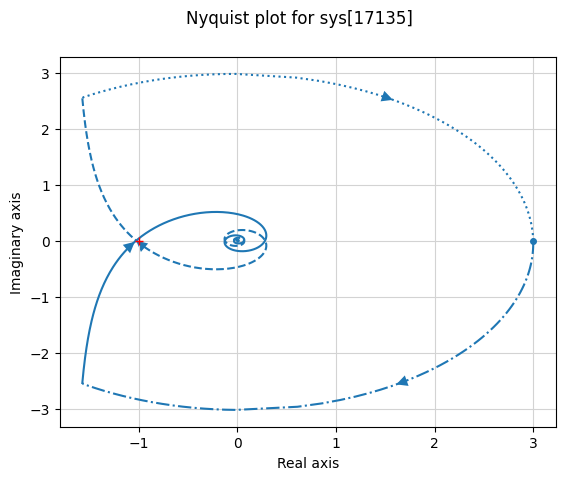

In [750]:
control.nyquist(Go * control.tf(*control.pade(0.56, n=6)), max_curve_magnitude=3)

2 states have been removed from the model


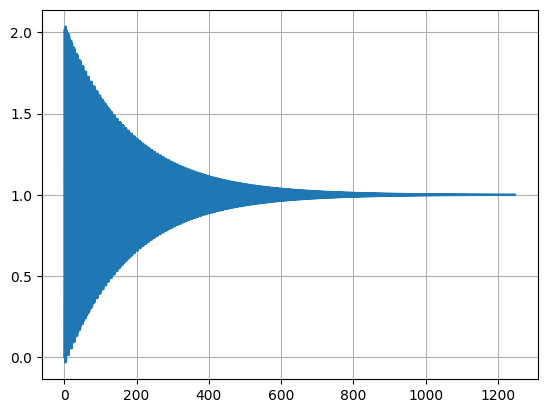

In [725]:
Y_R_delay = control.minreal(
    P * M * C / (1 + P * M * C * H * control.tf(*control.pade(0.54, n=6))), tol=1e-2
)

res = control.step_response(Y_R_delay)
plt.plot(res.t, res.y[0, 0, :])
plt.grid()